<a href="https://colab.research.google.com/github/ivoryRabbit/RecSys/blob/master/5_DeepRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepAutoRec

- [Training Deep AutoEncoders for Collaborative Filtering](https://arxiv.org/pdf/1708.01715.pdf)

## Experiment

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple, List
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

np.random.seed(777)
tf.random.set_seed(777)

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''

    if data_size == '1m':
        fname = 'ml-1m.zip'
        data = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        fname = 'ml-10m.zip'
        data = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        fname = 'ml-20m.zip'
        data = 'ml-20m/ratings.csv'
    elif data_size == '25m':
        fname = 'ml-25m.zip'
        data = 'ml-25m/ratings.csv'
    if not glob.glob(data):
        origin = f'http://files.grouplens.org/datasets/movielens/{fname}'
        file = get_file(fname, origin)
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall()

    col_names = ['user_id', 'movie_id', 'rating', 'timestamp']
    if data_size in ['20m', '25m']:
        ratings = pd.read_csv(data, engine = 'python')
    else:
        ratings = pd.read_csv(data, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
user_list = ratings.user_id.unique()
user_idx_map = {e: i for i, e in enumerate(user_list)}
n_user = len(user_list)
print(f'# of user = {n_user}')

item_list = ratings.movie_id.unique()
item_idx_map = {e: i for i, e in enumerate(item_list)}
n_item = len(item_list)
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [5]:
ratings = ratings.assign(
    user_id = ratings.user_id.map(user_idx_map),
    movie_id = ratings.movie_id.map(item_idx_map)
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


In [6]:
def binarizer(df: pd.DataFrame, threshold = 4) -> pd.DataFrame:
    df = df.assign(rating = np.where(df.rating >= threshold, 1, 0))
    return df[df.rating > 0.0].reset_index(drop = True)

def make_warm(df: pd.DataFrame, threshold = 5) -> pd.DataFrame: # remove cold starters
    positive = df.groupby('user_id')['movie_id'].count()
    positive = positive.index[positive >= threshold]
    return df[df.user_id.isin(positive)].reset_index(drop = True)

def train_valid_test_split(df: pd.DataFrame, size: float) -> pd.DataFrame:
    train_user, test_user = train_test_split(df.user_id.unique(), test_size = 2 * size, random_state = 777)
    valid_user, test_user = train_test_split(test_user, test_size = 0.5, random_state = 777)
    train, valid, test = map(lambda x: df[df.user_id.isin(x)], (train_user, valid_user, test_user))
    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    return train, valid, test

def query_relev_split(df: pd.DataFrame, size: float) -> pd.DataFrame:
    timeorder = df.groupby('user_id')['timestamp'].rank(method = 'first', ascending = True)
    seen_cnts = df.groupby('user_id')['movie_id'].transform('count')
    df = df.assign(seen_cnts = seen_cnts, timeorder = timeorder)
    query = df[df.timeorder < df.seen_cnts * (1-size)]
    relev = df[df.timeorder >= df.seen_cnts * (1-size)]
    relev = relev[relev.user_id.isin(query.user_id.unique())]
    query, relev = map(lambda df: df.drop(columns = ['timeorder', 'seen_cnts']), (query, relev))
    query, relev = map(lambda df: df.reset_index(drop = True), (query, relev))
    return query, relev

def list_agg(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('user_id', as_index = False)[['movie_id']].agg(list)

In [7]:
data = binarizer(ratings)
data = make_warm(data)
data.head()

,user_id,movie_id,rating,timestamp
0,0,0,1,978300760
1,0,3,1,978300275
2,0,4,1,978824291
3,0,6,1,978302039
4,0,7,1,978300719


In [8]:
train, valid, test = train_valid_test_split(data, size = 0.1)
valid_q, valid_r = query_relev_split(valid, size = 0.2)
test_q, test_r = query_relev_split(test, size = 0.2)

In [9]:
def train_generator(train: pd.DataFrame, 
                    n_item: int, 
                    batch_size: int) -> np.ndarray:

    train = list_agg(train)
    
    n_data = train.index.size
    ids = np.arange(n_data)
    profile = train['movie_id']

    n_batch = int(np.ceil(n_data / batch_size))
    while True:
        np.random.shuffle(ids)
        for batch_step in range(n_batch):     
            lower = batch_size * batch_step
            upper = batch_size + lower
            
            batch_id = ids[lower: upper]
            batch = np.zeros(shape = (batch_id.size, n_item), dtype = np.float32)
            for i, idx in enumerate(batch_id):
                batch[i, profile[idx]] = 1.0
            
            yield batch

In [10]:
def valid_generator(query: pd.DataFrame,
                    relev: pd.DataFrame,
                    n_item: int,
                    batch_size: int) -> Tuple[np.ndarray]:

    query = list_agg(query)
    relev = list_agg(relev)

    n_data = query.index.size
    ids = np.arange(n_data)
    profile_q = query['movie_id']
    profile_r = relev['movie_id']

    n_batch = int(np.ceil(n_data / batch_size))
    while True:
        np.random.shuffle(ids)
        for batch_step in range(n_batch):
            lower = batch_size * batch_step
            upper = batch_size + lower
            
            batch_id = ids[lower: upper]
            batch_q = np.zeros(shape = (batch_id.size, n_item), dtype = np.float32)
            batch_r = np.zeros(shape = (batch_id.size, n_item), dtype = np.float32)
            for i, idx in enumerate(batch_id):
                batch_q[i, profile_q[idx]] = 1.0 # seen
                batch_r[i, profile_r[idx]] = 1.0 # unseen

            yield batch_q, batch_r

In [11]:
def binary_cross_entropy(true: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    ce = tf.math.reduce_sum(K.binary_crossentropy(true, pred), axis = 1)
    return tf.math.reduce_mean(ce, axis = 0)

def multinomial(true: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    ll = tf.math.reduce_sum(true * K.log(pred), axis = 1)
    return -tf.math.reduce_mean(ll, axis = 0)

def batch_ndcg(query: tf.Tensor, 
               relev: tf.Tensor,
               pred: tf.Tensor, 
               weight: tf.Tensor,
               k = 100) -> tf.Tensor: # only for validation

    rec = tf.where(query == 1.0, -1.0, pred) # leave only unseen-data
    rec = tf.argsort(rec, axis = 1, direction = 'DESCENDING')[:, :k]
    shape = tf.shape(rec)

    row = tf.repeat(tf.range(shape[0]), shape[1])
    row = tf.expand_dims(row, axis = 1)
    col = tf.reshape(rec, shape = [-1])
    col = tf.expand_dims(col, axis = 1)
    loc = tf.concat([row, col], axis = 1)

    top_k = tf.reshape(tf.gather_nd(relev, loc), shape = shape)
    ideal = tf.sort(relev, axis = 1, direction = 'DESCENDING')[:, :k]
    weight = weight[:shape[1]]

    dcg = tf.reduce_sum(top_k * weight, axis = 1)
    idcg = tf.reduce_sum(ideal * weight, axis = 1)
    return tf.reduce_mean(dcg / idcg, axis = 0)

In [12]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, units, n_layer):
        super(Encoder, self).__init__()
        self.units = units
        self.n_layer = n_layer
        self.encoders = []

    def build(self, input_shape):
        for i in range(self.n_layer-1):
            self.encoders.append(
                Dense(self.units * 2,
                      activation = 'selu',
                      kernel_initializer = 'glorot_uniform',
                      bias_initializer = 'zeros',
                      kernel_regularizer = l2,
                      name = f'encoder_{i+1}')
            )
        self.encoders.append(
            Dense(self.units,
                  activation = 'selu',
                  kernel_initializer = 'glorot_uniform',
                  bias_initializer = 'zeros',
                  kernel_regularizer = l2,
                  name = f'encoder_{i+2}')
        )

    def call(self, inputs):
        outputs = inputs
        for i in range(self.n_layer):
            outputs = self.encoders[i](outputs)
        return outputs

In [13]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, units, n_layer):
        super(Decoder, self).__init__()
        self.units = units
        self.n_layer = n_layer
        self.decoders = []

    def build(self, input_shape):
        for i in range(self.n_layer-1):
            self.decoders.append(
                Dense(input_shape[1] * 2,
                      activation = 'selu',
                      kernel_initializer = 'glorot_uniform',
                      bias_initializer = 'zeros',
                      kernel_regularizer = l2,
                      name = f'decoder_{i+1}')
            )
        self.decoders.append(
            Dense(self.units,
                  activation = 'sigmoid',
                  kernel_initializer = 'glorot_uniform',
                  bias_initializer = 'zeros',
                  kernel_regularizer = l2,
                  name = f'decoder_{i+2}')
        )
        
    def call(self, inputs):
        outputs = inputs
        for i in range(self.n_layer):
            outputs = self.decoders[i](outputs)
        return outputs

In [14]:
class DeepRec(tf.keras.models.Model):
    def __init__(self, input_dim, latent_dim, n_layer, gamma):
        super(DeepRec, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_layer = n_layer
        self.gamma = gamma

        self.encoder = Encoder(self.latent_dim, self.n_layer)
        self.decoder = Decoder(self.input_dim, self.n_layer)

        _ = self.call(Input(shape = (self.input_dim, )))
        self.build(input_shape = (None, self.input_dim))

    def call(self, inputs):
        h = self.encoder(inputs)
        return self.decoder(h)

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            outputs = self(inputs)
            loss = self.loss(inputs, outputs)
        grad = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))

        with tf.GradientTape() as tape_ref:
            refeeds = self(outputs)
            loss_ref = self.gamma * self.loss(outputs, refeeds)
        grad_ref = tape_ref.gradient(loss_ref, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_ref, self.trainable_variables))
        return {'loss': loss + loss_ref}

    def test_step(self, data):
        query, relev = data
        pred = self(query)

        weight = tf.range(2, self.input_dim, dtype = 'float32')
        weight = tf.math.reciprocal(tf.math.log(weight))
        ndcg = batch_ndcg(query, relev, pred, weight)
        return {'ndcg': ndcg}

In [15]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 6))

    ax1.plot(hist.history[f'{loss}'])
    ax1.set_title(loss, fontsize = 20)
    ax1.set_ylabel(loss)
    ax1.set_xlabel('epoch')

    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title(metric, fontsize = 20)
    ax2.set_ylabel(metric)
    ax2.set_xlabel('epoch')
    plt.tight_layout()

In [31]:
epochs = 100
batch_size = 128

train_gen = train_generator(train, n_item, batch_size)
valid_gen = valid_generator(valid_q, valid_r, n_item, batch_size)

steps_per_epoch = train.user_id.nunique() // batch_size + 1
validation_steps = valid.user_id.nunique() // batch_size + 1

In [32]:
model = DeepRec(n_item, latent_dim = 128, n_layer = 3, gamma = 0.1)
model.compile(optimizer = Adam(lr = 1e-4), loss = binary_cross_entropy)

model.summary()

Model: "deep_rec_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          (None, 128)               1047680   
_________________________________________________________________
decoder_2 (Decoder)          (None, 3706)              1051258   
Total params: 2,098,938
Trainable params: 2,098,938
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
38/38 [==============================] - 1s 15ms/step - loss: 1613.4201 - val_ndcg: 0.1308
Epoch 2/100
38/38 [==============================] - 0s 9ms/step - loss: 427.9304 - val_ndcg: 0.1675
Epoch 3/100
38/38 [==============================] - 0s 9ms/step - loss: 355.7357 - val_ndcg: 0.1413
Epoch 4/100
38/38 [==============================] - 0s 12ms/step - loss: 335.5507 - val_ndcg: 0.1607
Epoch 5/100
38/38 [==============================] - 0s 9ms/step - loss: 331.9359 - val_ndcg: 0.1625
Epoch 6/100
38/38 [==============================] - 0s 9ms/step - loss: 327.4880 - val_ndcg: 0.1596
Epoch 7/100
38/38 [==============================] - 0s 8ms/step - loss: 326.1458 - val_ndcg: 0.1433
Epoch 8/100
38/38 [==============================] - 0s 9ms/step - loss: 325.7792 - val_ndcg: 0.1379
Epoch 9/100
38/38 [==============================] - 0s 8ms/step - loss: 325.5526 - val_ndcg: 0.1509
Epoch 10/100
38/38 [==============================] - 0s 8ms/step - loss: 323.6060 - val

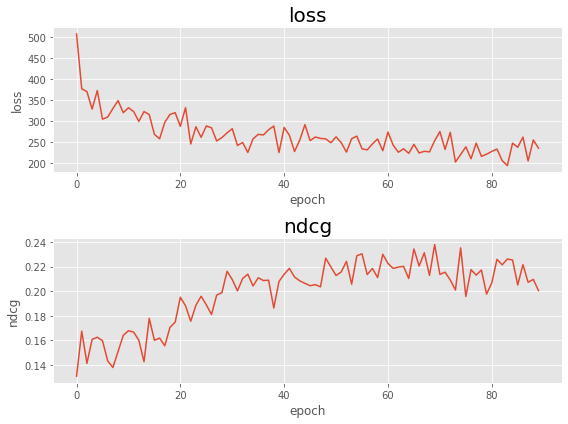

In [33]:
%%time
early_stopping = EarlyStopping(monitor = 'val_ndcg', mode = 'max', verbose = 1, patience = epochs // 5)
model_checkpoint = ModelCheckpoint('DeepRec.h5', monitor = 'val_ndcg', mode = 'max', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])
show_history(hist, 'loss', 'ndcg')

In [34]:
def test_predictor(query: pd.DataFrame, 
                   model: Callable,
                   n_item: int, 
                   batch_size: int, 
                   N = 100) -> float:

    query = list_agg(query)

    n_data = query.index.size
    ids = np.arange(n_data)
    profile = query['movie_id']

    pred = []
    n_batch = int(np.ceil(n_data / batch_size))
    for batch_step in range(n_batch):
        lower = batch_size * batch_step
        upper = batch_size + lower

        batch_id = ids[lower: upper]
        batch = np.zeros(shape = (batch_id.size, n_item))
        for i, idx in enumerate(batch_id):
            batch[i, profile[idx]] = 1.0

        pred_batch = model.predict(batch, verbose = 0)
        
        rec = np.argsort(np.where(batch == 1.0, -1.0, pred_batch), axis = 1)[:, :-N-1:-1]
        pred.append(rec)
    pred = np.concatenate(pred)
    pred = [{'user_id': query.at[i, 'user_id'], 'movie_id': pred[i]} for i in range(n_data)]
    return pd.DataFrame(pred)

In [35]:
class evaluate:
    def __init__(self, true: pd.DataFrame, pred: pd.DataFrame):
        self.true = true
        self.pred = pred
        self.max_K = 10000
        self.idcg = np.cumsum([1.0 / np.log(i+2) for i in range(self.max_K)])

    def _recall(self, gt: List, rec: List, K = None) -> float:
        K = K if K else self.max_K
        res = [r for r in rec[:K] if r in gt]
        return len(res) / np.min([K, len(gt)])
    
    def _precision(self, gt: List, rec: List, K = None) -> float:
        K = K if K else self.max_K
        res = [r for r in rec[:K] if r in gt]
        return len(res) / len(rec[:K])

    def _AP(self, gt: List, rec: List, K = None) -> float: # Average Precision
        K = K if K else self.max_K
        res = 0.0
        for i, r in enumerate(rec[:K]):
            if r in gt:
                res += self._precision(gt, rec[:K], i+1)
        return res / np.min([K, len(gt)])

    def _RR(self, gt: List, rec: List, K = None) -> float: # Reciprocal Rank
        K = K if K else self.max_K
        for i, r in enumerate(rec[:K]):
            if r in gt:
                return  1.0 / (i+1)
        return 0

    def _nDCG(self, gt: List, rec: List, K = None) -> float: # normalized Discounted Cumulative Gain
        K = K if K else self.max_K
        dcg = 0.0
        for i, r in enumerate(rec[:K]):
            if r in gt:
                dcg += 1.0 / np.log(i+2)
        idcg = self.idcg[min([len(gt), K])-1]
        return dcg / idcg
    
    def __call__(self, K = None):
        self.K = K
        self.recall = 0
        self.precision = 0
        self.MAP = 0
        self.MRR = 0
        self.nDCG = 0
        n = self.true.index.size
        for gt, rec in zip(tqdm(self.true.movie_id), self.pred.movie_id):
            self.recall += self._recall(gt, rec, K) / n
            self.precision += self._precision(gt, rec, K) / n
            self.MAP += self._AP(gt, rec, K) / n
            self.MRR += self._RR(gt, rec, K) / n
            self.nDCG += self._nDCG(gt, rec, K) / n

    def print_all(self):
        K = '@' + str(self.K) if self.K else ''
        print(f'{"Recall":>12}{K} : {self.recall:.5f}',
              f'\n{"Precision":>12}{K} : {self.precision:.5f}',
              f'\n{"MAP":>12}{K} : {self.MAP:.5f}',
              f'\n{"MRR":>12}{K} : {self.MRR:.5f}',
              f'\n{"nDCG":>12}{K} : {self.nDCG:.5f}')

In [36]:
true = list_agg(test_r)
true.head(5)

,user_id,movie_id
0,2,"[177, 179, 183, 84, 4, 198, 199, 207]"
1,8,"[59, 438, 93, 123, 463, 525, 30, 288, 534, 322..."
2,41,"[175, 182, 563, 184, 1176, 116, 128, 1037, 104..."
3,78,"[1258, 305, 500, 2230]"
4,91,"[558, 1176, 195, 587, 592, 74, 1904, 186, 647,..."


In [37]:
pred = test_predictor(test_q, model, n_item, batch_size, N = 100)
pred.head(5)

,user_id,movie_id
0,2,"[92, 678, 48, 1041, 60, 711, 792, 78, 132, 386..."
1,8,"[244, 134, 184, 5, 221, 315, 506, 92, 256, 39,..."
2,41,"[132, 856, 160, 189, 112, 62, 155, 86, 48, 110..."
3,78,"[531, 1232, 406, 499, 113, 524, 104, 321, 68, ..."
4,91,"[8, 44, 9, 612, 596, 682, 741, 609, 116, 64, 6..."


In [38]:
scores = evaluate(true, pred)

scores(K = 20)
scores.print_all()

scores(K = 100)
scores.print_all()


      Recall@20 : 0.14843 
   Precision@20 : 0.08121 
         MAP@20 : 0.04550 
         MRR@20 : 0.23323 
        nDCG@20 : 0.12153



      Recall@100 : 0.39990 
   Precision@100 : 0.05626 
         MAP@100 : 0.06030 
         MRR@100 : 0.24086 
        nDCG@100 : 0.21689
